In [1]:
import pandas as pn
import numpy as np
import pymc3 as pm
import theano.tensor as tt

from theano import shared
from sklearn.metrics import confusion_matrix, roc_curve

# Read and clean data

In [2]:
# Read data
data = pn.read_csv("../data/cancer_data.csv")

Features from cell nuclei from a needle aspiration on a tumor

![](../resources/cells.png)

In [3]:
# Look at it
data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [4]:
# Remove malformed column
data = data.drop("Unnamed: 32", axis=1)

([<matplotlib.axis.XTick at 0x7f3c17484a20>,
 <a list of 2 Text xticklabel objects>)

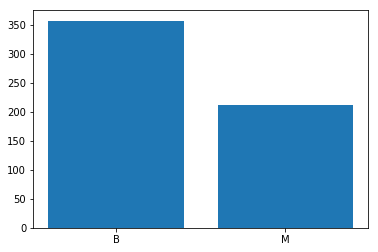

In [5]:
# The variable we're interested in is categorical with two classes
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

counts = data.groupby("diagnosis")["id"].count()
plt.bar(np.arange(counts.shape[0]), data.groupby("diagnosis")["id"].count())
plt.xticks(np.arange(counts.shape[0]), counts.index)


# Prepare the data

In [6]:
# Train and test
np.random.seed(42)
is_train = np.random.rand(len(data)) < 0.8
train = data[is_train]
test = data[~is_train]
train.to_csv("../data/cancer_train.csv")
test.to_csv("../data/cancer_test.csv")

In [7]:
# Standardize the predictors
X = np.array(train.iloc[:, 2:])
mX, sX = X.mean(axis=0), X.std(axis=0)
scaled = (X - mX)/sX

# Add bias term
predictors = np.c_[np.ones(scaled.shape[0]), scaled]

# Transform response to boolean
y = np.array(train.diagnosis == "M")

# Build model and make inference

In [8]:
# Model
n_predictors = predictors.shape[1]
predictors = shared(predictors)

with pm.Model() as model:
    beta = pm.Cauchy("beta", 0, 2.5, shape=n_predictors)
    p = 1/(1 + tt.exp(tt.dot(predictors, beta)))
    obs = pm.Bernoulli("obs", p, observed=y)

/home/adolfo/.pyenv/versions/3.5.2/envs/love_uncertainty/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


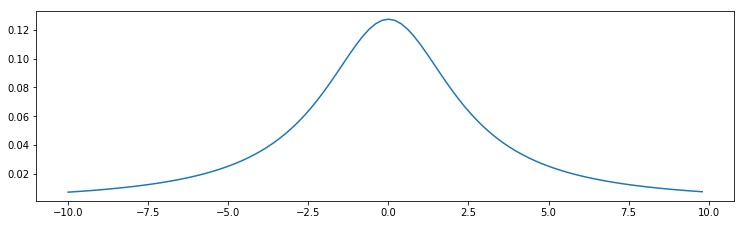

In [9]:
# Plot Prior
from scipy.stats import cauchy, norm
prior = cauchy(loc=0, scale=2.5)
x = np.arange(-10, 10, 0.2)
y = prior.pdf(x)

figsize(12.5, 3.5)
plt.plot(x, prior.pdf(x))

In [10]:
# Inference
with model:
    step = pm.Metropolis()
    trace = pm.sample(50000, step=step, random_seed=42)
    burned = trace[40000:]

100%|██████████| 50000/50000 [00:13<00:00, 3712.64it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c1740f470>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3c15fdd278>]], dtype=object)

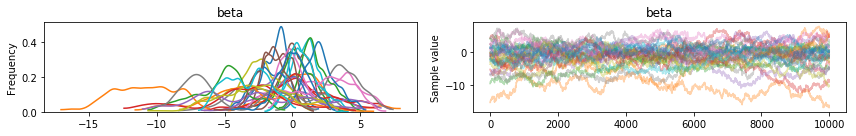

In [11]:
# Traceplot
pm.traceplot(burned)

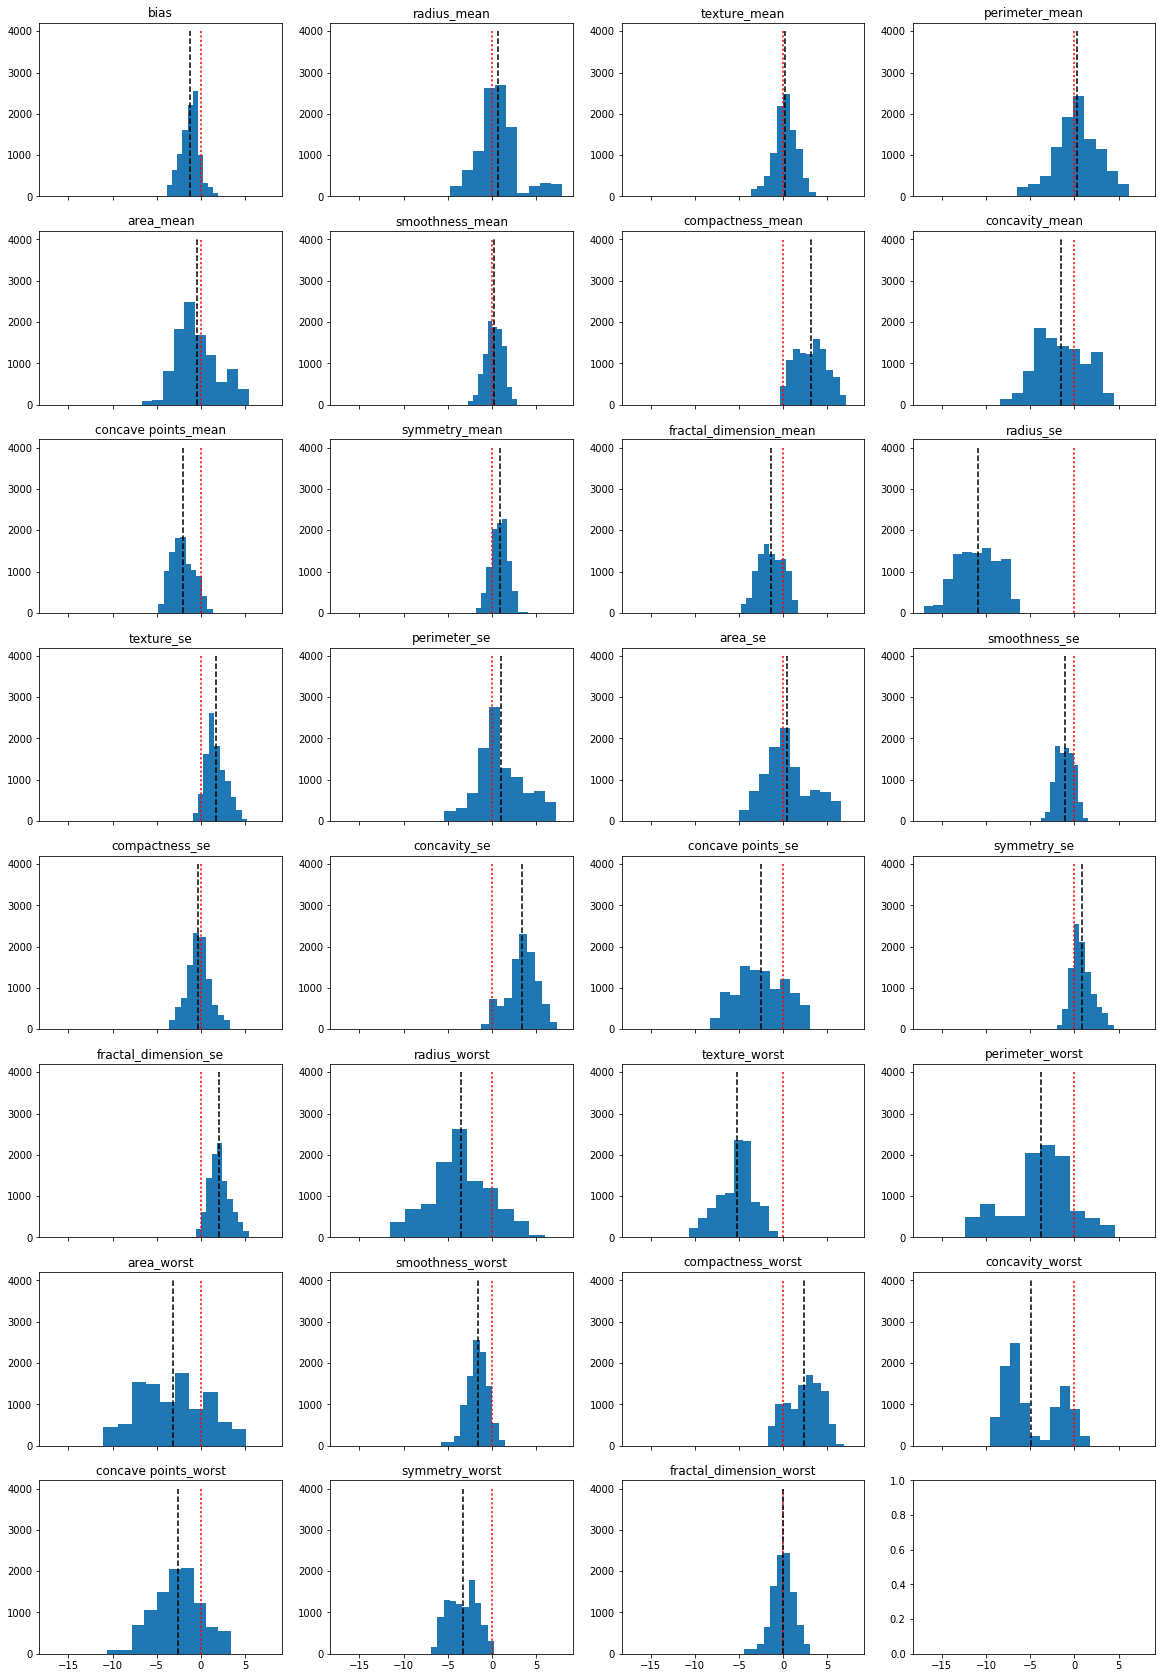

In [12]:
# Plot Posteriors
figsize(20, 30)
m, n = 8, 4
f, axes = plt.subplots(m, n, squeeze=True, sharex=True)

varnames = data.columns[2:].insert(0, "bias")
for i in np.arange(m):
    for j in np.arange(n):
        k = i*n+j
        if k < len(burned["beta"].T):
            var = burned["beta"].T[k]
            axes[i][j].hist(var)
            axes[i][j].vlines([0, var.mean()], 0, 4000, colors=["red", "black"], linestyles=["dotted", "dashed"])
            axes[i][j].set_title(varnames[k])

pn.DataFrame(burned["beta"].T).T.to_csv("../data/cancer_posteriors.csv", index=False, header=varnames)


# Predict on testing set

In [13]:
# Standardize testing set
X_test = np.array(test.iloc[:, 2:])
scaled_test = (X_test - mX)/sX

# Add bias
predictors_test = np.c_[np.ones(scaled_test.shape[0]), scaled_test]


In [14]:
    # Set theano shared object to testing predictors and sample from the predictive distribution
    predictors.set_value(predictors_test)
    pred_samples = pm.sample_ppc(burned, model=model, samples=10000, progressbar=True)

100%|██████████| 10000/10000 [00:26<00:00, 380.44it/s]


In [15]:
thresh = 0.5

pn.DataFrame({"y": test.diagnosis=="M", "prob": pred_samples["obs"].mean(axis=0)}).to_csv("../data/cancer_probs.csv",
                                                                                         header=True, index=False)
confusion_matrix(y_true=(test.diagnosis=="M"), y_pred=pred_samples["obs"].mean(axis=0) > thresh)



array([[83,  0],
       [ 2, 42]])

# Why is uncertainty important?

In [16]:
# Get the realizations of p
p_posterior_samples = np.array([1/(1 + np.exp(np.dot(predictors_test, beta_sample))) for beta_sample in burned["beta"]])
p_posterior_estimates = p_posterior_samples.mean(axis=0)

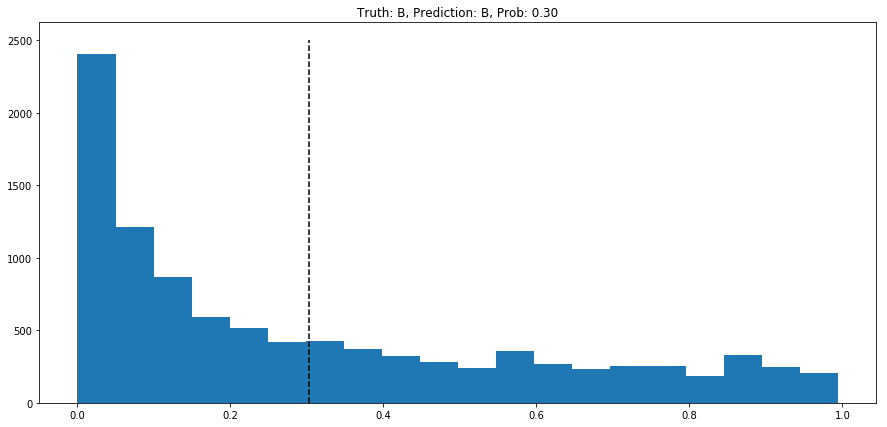

In [17]:
# Choose an 'interesting' case
figsize(15, 7)
idx = [i for i, p in enumerate(p_posterior_estimates) if p > 0.2 and p < 0.5]

plt.hist(p_posterior_samples.T[idx[0]], bins=20)
plt.vlines(p_posterior_estimates[idx[0]], 0, 2500, linestyles="dashed")

p = p_posterior_estimates[idx[0]]
pred = "M" if p > thresh else "B"
plt.title("Truth: {}, Prediction: {}, Prob: {:.2f}".format(test.diagnosis.iloc[idx[0]], pred, p))

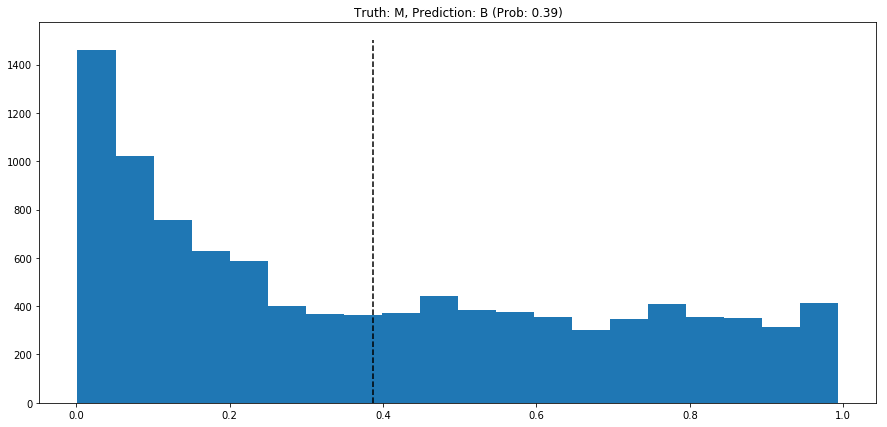

In [18]:
# Another 'interesting' case
plt.hist(p_posterior_samples.T[idx[-1]], bins=20)
plt.vlines(p_posterior_estimates[idx[-1]], 0, 1500, linestyles="dashed")
p = p_posterior_estimates[idx[-1]]
pred = "M" if p > thresh else "B"
plt.title("Truth: {}, Prediction: {} (Prob: {:.2f})".format(test.diagnosis.iloc[idx[-1]], "B", p_posterior_estimates[idx[-1]]))

# What if the payoff is different?

We choose the threshold of 0.5 based on a loss matrix:

$$ L = 
\begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}
$$

and the minimization of the expected loss:

$$ E_{L} = \sum_{k \in K} L(k, l)Pr(k | x) $$

where $K$ is the set of classes and $l$ is the predicted class, and $L(k,l) = L_{kl}$

Such a loss matrix encodes the same penalization for a false positive for a false negative. What if we change this?

$$ L =
\begin{bmatrix}
0 & 1 \\
2 & 0
\end{bmatrix}
$$

In this case, we're penalizing a false negative **twice** as much as a false positive, then by minimizing the expected loss we have that 

$$ l^* = argmin \{2p, 1-p\} $$

Which implies $$l^* = 1$$ if $p > 1/3$ and $$l^*=0$$ otherwise

In [19]:
thresh = 1/3
confusion_matrix(y_true=(test.diagnosis=="M"), y_pred=pred_samples["obs"].mean(axis=0) > thresh)

array([[83,  0],
       [ 1, 43]])

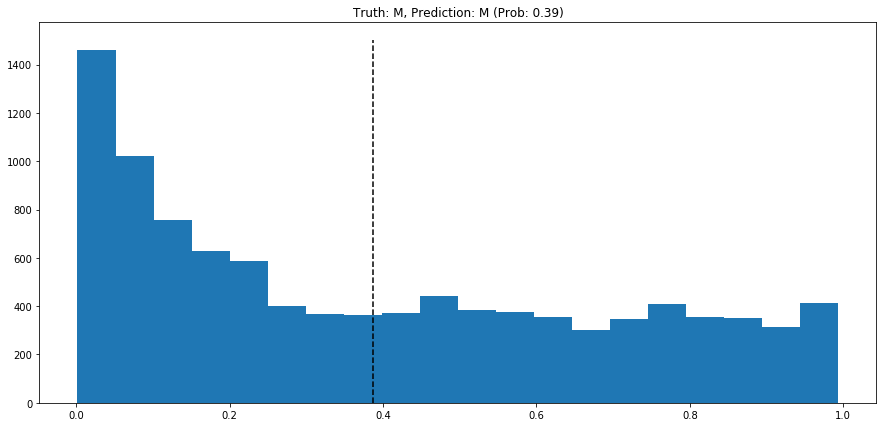

In [20]:
plt.hist(p_posterior_samples.T[idx[-1]], bins=20)
plt.vlines(p_posterior_estimates[idx[-1]], 0, 1500, linestyles="dashed")
p = p_posterior_estimates[idx[-1]]
pred = "M" if p > thresh else "B"
plt.title("Truth: {}, Prediction: {} (Prob: {:.2f})".format(test.diagnosis.iloc[idx[-1]], pred, p))

In [21]:
pn.DataFrame(p_posterior_samples.T[[idx[0], idx[-1]]].T).to_csv("../data/cancer_predictives.csv", index=False, header=False)